# Preparación y curación de los datos

### Tabla de Contenidos
1. [Inicialización del entorno](#1.-Inicialización-del-entorno)
2. [Carga de datos de las sesiones](#2.-Carga-de-datos-de-las-sesiones)
3. [Carga de datos de los mensajes](#3.-Carga-de-datos-de-los-mensajes)
4. [Conteo de palabras en los mensajes](#4.-Conteo-de-palabras-en-los-mensajes)
5. [Join de los datasets](#5.-Join-de-los-datasets)
6. [Categorización de la variable objetivo](#6.-Categorización-de-la-variable-objetivo)
7. [Remoción de columnas](#7.-Remoción-de-columnas)
8. [Guardado del archivo de resultados](#8.-Guardado-del-archivo-de-resultados)
9. [Información del conjunto de datos generado](#9.-Información-del-conjunto-de-datos-generado)

## 1. Inicialización del entorno

In [17]:
# Librerías básicas
import os
import pandas as pd
import numpy as np
import math

# Librerías para gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías necesarias para el conteo de palabras
from ast import literal_eval
from collections import Counter

# Archivo externo con la definición de las columnas a ser cargadas
from columns_to_keep import C2K

# Archivo externo para conversión de tipos de datos
from type_to_fix import T2F

## 2. Carga de datos de las sesiones

Cargamos los datos de las sesiones. Cada fila contiene información acerca de una sesión entre tutor y estudiante

In [18]:
data_dir = os.path.join('..', 'dataset')

# dataset de sesiones
md_data_file_name = 'datadump-20150801-20171219.csv'
md_full_data_file_name = os.path.join(data_dir, md_data_file_name)
md_df = pd.read_csv(md_full_data_file_name, low_memory=False)

# dataset de sesiones
md_df.columns = [column.strip() for column in md_df.columns]
md_df = md_df[C2K]
md_df = md_df.astype(T2F)

# Caracterización del dataset de sesiones
print ('\nDimensiones del dataset de sesiones\n' + '-'*50)
print ('Filas: {}'.format(md_df.shape[0]))
print ('Columnas: {}\n'.format(md_df.shape[1]))
print ('Cantidad de sesiones: ', md_df['session_id'].nunique())


Dimensiones del dataset de sesiones
--------------------------------------------------
Filas: 63265
Columnas: 39

Cantidad de sesiones:  63265


## 3. Carga de datos de los mensajes

Cargamos los datos de los mensajes. Cada fila contiene información sobre un mensaje originado por el tutor, el estudiante o de algun agente (bot, system). Esta información incluye el texto del mensaje.

In [19]:
# dataset de mensajes
#msg_data_file_name = 'dev_yup_messages_preprocessed.csv'
#msg_data_file_name = 'train_yup_messages_preprocessed.csv'
#msg_data_file_name = 'test_yup_messages_preprocessed.csv'
msg_data_file_name = 'yup_messages_preprocessed.csv'

msg_full_data_file_name = os.path.join(data_dir, msg_data_file_name)
msg_df = pd.read_csv(msg_full_data_file_name)
msg_df = msg_df.astype({'created_at': 'datetime64[ns, UTC]'})


# Caracterización del dataset de mensajes
print ('\nDimensiones del dataset de mensajes\n' + '-'*50)
print ('Filas: {}'.format(msg_df.shape[0]))
print ('Columnas: {}\n'.format(msg_df.shape[1]))
print ('Cantidad de sesiones (en el dataset de mensajes): ', msg_df['session_id'].nunique())
print ('Cantidad de turnos (total): {}'.format(msg_df.shape[0]))
print ('Cantidad de turnos del tutor: {}'.format(len(msg_df[msg_df.sent_from=='tutor'])))
print ('Cantidad de turnos del estudiante: {}'.format(len(msg_df[msg_df.sent_from=='student'])))


Dimensiones del dataset de mensajes
--------------------------------------------------
Filas: 1574069
Columnas: 6

Cantidad de sesiones (en el dataset de mensajes):  25693
Cantidad de turnos (total): 1574069
Cantidad de turnos del tutor: 810024
Cantidad de turnos del estudiante: 601453


## 4. Conteo de palabras en los mensajes

Realizamos el conteo de palabras en los mensajes, para el tutor y el estudiante. A partir del cálculo de la longitud de los mensajes por turno, obtenemos para el tutor y el estudiante:

* Cantidad de mensajes por sesión
* Cantidad de palabras por sesión
* Longitud de mensaje promedio (cantidad promedio de palabras) por sesión

También:

* Cantidad de mensajes de bot
* Cantidad de mensajes del sistema
* Canridad de mensajes cuyo contenido es texto
* Canridad de mensajes cuyo contenido es imagen

In [20]:
# Cálculo de las longitudes de los mensajes (cantidad de palabas)

msg_df['tokens'] = msg_df.text.apply(lambda x: literal_eval(x))
msg_df['n_words'] = msg_df.tokens.apply(lambda x: len(x))

In [21]:
# Conteo de palabras tutor y estudiante

agg_tutor_msg_df = msg_df[msg_df['sent_from']=='tutor'].groupby('session_id').agg(
    avg_words_tutor = ('n_words', np.mean),
    n_words_tutor = ('n_words', sum),
    n_msg_tutor = ('sent_from', lambda x: x.eq('tutor').sum()),
    tokens_tutor = ('tokens', lambda x: x.sum())
)
agg_student_msg_df = msg_df[msg_df['sent_from']=='student'].groupby('session_id').agg(
    avg_words_student = ('n_words', np.mean),
    n_words_student = ('n_words', sum),
    n_msg_student = ('sent_from', lambda x: x.eq('student').sum()),
    tokens_student = ('tokens', lambda x: x.sum())
)

In [22]:
# Otras agregaciones del dataset de mensajes 

agg_msg_df = msg_df.groupby('session_id').agg(
        # started =('created_at', min),
        # ended =('created_at', max),
        duration = ('created_at', lambda x: (max(x) - min(x))),
        n_msg_bot = ('sent_from', lambda x: x.eq('bot').sum()),
        n_msg_system = ('sent_from', lambda x: x.isin(list(['system alert', 'system info', 'system warn'])).sum()),
        n_msg_content_text = ('content_type', lambda x: x.eq('text').sum()),
        n_msg_content_image = ('content_type', lambda x: x.eq('image').sum())
        # tokens = ('tokens', lambda x: x.sum()),
)

In [23]:
print ('\nDimensiones de los datasets (cantidad de filas)\n')
print('Conteos del Tutor: {}'.format(agg_tutor_msg_df.shape[0]))
print('Conteos del Estudiante: {}'.format(agg_student_msg_df.shape[0]))
print('Otros conteos: {}'.format(agg_msg_df.shape[0]))


Dimensiones de los datasets (cantidad de filas)

Conteos del Tutor: 22359
Conteos del Estudiante: 25195
Otros conteos: 25693


## 5. Join de los datasets

Combinamos el dataset de sesiones con los datasets obtenidos a partir de los conteos del dataset de mensajes. La cantidad 

In [24]:
# Joins
res_df = pd.merge(md_df, agg_msg_df, on=["session_id", "session_id"])
res_df = pd.merge(res_df, agg_tutor_msg_df, how="left", on=["session_id", "session_id"])
res_df = pd.merge(res_df, agg_student_msg_df, how="left", on=["session_id", "session_id"])

# Llenar los NAN producto del left join con ceros
res_df['avg_words_tutor'] = res_df['avg_words_tutor'].fillna(0)
res_df['n_words_tutor'] = res_df['n_words_tutor'].fillna(0)
res_df['n_msg_tutor'] = res_df['n_msg_tutor'].fillna(0)

res_df['avg_words_student'] = res_df['avg_words_student'].fillna(0)
res_df['n_words_student'] = res_df['n_words_student'].fillna(0)
res_df['n_msg_student'] = res_df['n_msg_student'].fillna(0)

In [25]:
print ('\nDimensiones del dataset (cantidad de filas)\n')
print('Dataset combinado (datos de las sesiones + conteos + tokens): {}'.format(agg_msg_df.shape[0]))


Dimensiones del dataset (cantidad de filas)

Dataset combinado (datos de las sesiones + conteos + tokens): 25693


## 6. Categorización de la variable objetivo
Creamos una variable categórica `student_rating_cat` a partir de la variable `student_rating`. Esta representa la clase que buscamos predecir. Para valores menores o iguales a 2 que consideramos feedback negativo asignaremos la clase 0, mientras que valores mayores o iguales a 4 serán considerados positivos (clase 1)

Removeremos las filas evaluadas como neutras, es defir aquellas con calificación 3



In [26]:
# Categorización de la variable student_rating

def student_rating_category(x):
    
    if x <= 2:
        return 0
    
    if x >= 4:
        return 1

    return 'neutra'

# Eliminamos las filas nulas
print ('\nRemoción de {} sesiones que no tienen valor para variable student_rating'.format(res_df['student_rating'].isnull().sum()))
res_df = res_df.dropna(subset=['student_rating'])

# Categorización de la variable objetivo
res_df['student_rating_cat'] = res_df.student_rating.apply(student_rating_category)

# Remoción de las filas con calificación neutra
print ('Remoción de {} sesiones calificadas como neutras'.format(len(res_df[res_df['student_rating_cat'] == 'neutra'])))
res_df = res_df.loc[res_df.student_rating_cat != 'neutra']


Remoción de 7476 sesiones que no tienen valor para variable student_rating
Remoción de 788 sesiones calificadas como neutras


In [27]:
# Caracterización del dataset combinado
print ('\nDimensiones del dataset combinado\n')
print ('Filas: {}'.format(res_df.shape[0]))
print ('Columnas: {}'.format(res_df.shape[1]))
print ('Cantidad de sesiones:', res_df['session_id'].nunique())


Dimensiones del dataset combinado

Filas: 17429
Columnas: 53
Cantidad de sesiones: 17429


## 7. Remoción de columnas 
Removemos las columnas que no se usarán para predecir la variable objetivo

In [28]:
columns_to_keep = list()
columns_to_keep.append('tutor_id')
columns_to_keep.append('tutor_age')
columns_to_keep.append('session_tag_no_material')
columns_to_keep.append('session_tag_student_left')
columns_to_keep.append('session_tag_student_not_engaging')
columns_to_keep.append('student_complained')
columns_to_keep.append('student_complaint_clarity')
columns_to_keep.append('student_complaint_speed')
columns_to_keep.append('student_complaint_subject')
columns_to_keep.append('student_complaint_other')
columns_to_keep.append('session_tag_cheating')
columns_to_keep.append('session_tag_inappropriate')
columns_to_keep.append('session_tag_other_subject')
columns_to_keep.append('avg_words_tutor')
columns_to_keep.append('n_words_tutor')
columns_to_keep.append('n_msg_tutor')
columns_to_keep.append('avg_words_student')
columns_to_keep.append('n_words_student')
columns_to_keep.append('n_msg_student')
columns_to_keep.append('tokens_tutor')
columns_to_keep.append('tokens_student')
# columns_to_keep.append('tokens')
columns_to_keep.append('student_rating_cat')

final_df = res_df[columns_to_keep]

final_df = final_df.astype({'student_rating_cat':int})

mean_tutor_age = final_df.tutor_age.mean().astype(int)
for i in final_df[final_df.tutor_age.isna()].index:
    final_df.loc[i, ['tutor_age']] = mean_tutor_age

## 8. Guardado del archivo de resultados

In [29]:
# Salva archivo csv con el prefijo del archivo procesado

curated_data_file_name = msg_data_file_name.split('_')[0] + '_curated_data.csv'
curated_full_data_file_name = os.path.join(data_dir, curated_data_file_name)
final_df.to_csv(curated_full_data_file_name, index=False)

## 9. Información del conjunto de datos generado

In [30]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17429 entries, 0 to 25692
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   tutor_id                          17429 non-null  Int64  
 1   tutor_age                         17429 non-null  Int64  
 2   session_tag_no_material           17429 non-null  Int64  
 3   session_tag_student_left          17429 non-null  Int64  
 4   session_tag_student_not_engaging  17429 non-null  Int64  
 5   student_complained                17429 non-null  Int64  
 6   student_complaint_clarity         17429 non-null  Int64  
 7   student_complaint_speed           17429 non-null  Int64  
 8   student_complaint_subject         17429 non-null  Int64  
 9   student_complaint_other           17429 non-null  Int64  
 10  session_tag_cheating              17429 non-null  Int64  
 11  session_tag_inappropriate         17429 non-null  Int64  
 12  sess

### Descripción del conjunto de datos generado

In [31]:
final_df.describe()

,tutor_id,tutor_age,session_tag_no_material,session_tag_student_left,session_tag_student_not_engaging,student_complained,student_complaint_clarity,student_complaint_speed,student_complaint_subject,student_complaint_other,session_tag_cheating,session_tag_inappropriate,session_tag_other_subject,avg_words_tutor,n_words_tutor,n_msg_tutor,avg_words_student,n_words_student,n_msg_student,student_rating_cat
count,17429.000000,17429.000000,17429.000000,17429.000000,17429.000000,17429.0,17429.0,17429.0,17429.0,17429.0,17429.000000,17429.000000,17429.000000,17429.000000,17429.000000,17429.000000,17429.000000,17429.000000,17429.000000,17429.000000
mean,136277.454472,37.166045,0.018131,0.094268,0.014516,0.0,0.0,0.0,0.0,0.0,0.011131,0.017959,0.009467,11.507026,427.743760,41.699466,4.071113,128.776924,30.621091,0.793562
std,149987.026748,13.634482,0.133428,0.292210,0.119608,0.0,0.0,0.0,0.0,0.0,0.104917,0.132805,0.096840,4.705331,465.027859,48.330339,2.144409,146.949457,32.894722,0.404760
min,2.000000,15.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34864.000000,23.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,8.625000,120.000000,10.000000,2.762376,35.000000,10.000000,1.000000
50%,49985.000000,33.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,10.600000,286.000000,27.000000,3.769231,84.000000,21.000000,1.000000
75%,281457.000000,52.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,13.400000,567.000000,55.000000,5.000000,166.000000,39.000000,1.000000
max,510148.000000,63.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,59.000000,8062.000000,824.000000,125.750000,2202.000000,563.000000,1.000000


### Visualización del balanceo de clases en la variable a predecir

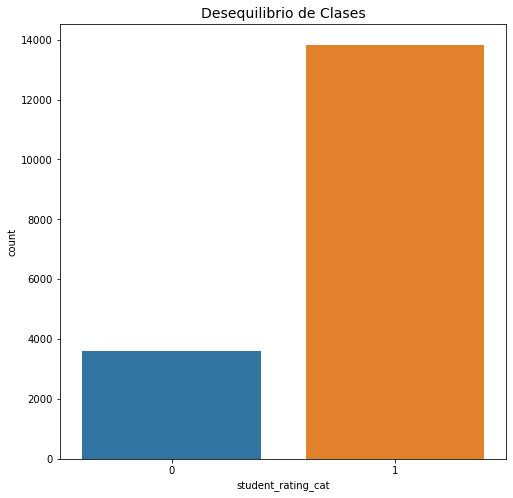

In [32]:
plt.figure(figsize=(8, 8))
sns.countplot('student_rating_cat', data=final_df)
plt.title('Desequilibrio de Clases', fontsize=14)
plt.show()